In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

from sklearn.model_selection import train_test_split



from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.model_selection import GridSearchCV

In [2]:
app_record = pd.read_csv('application_record.csv')
credit_record = pd.read_csv('credit_record.csv')

In [3]:
print('Total Application record: ', len(app_record))
print('Total Credit record: ', len(credit_record))

Total Application record:  438557
Total Credit record:  1048575


In [4]:
print('Unique Client Number: ', len(app_record.ID.unique()))
print('Unique Client Number:', len(credit_record.ID.unique()))

Unique Client Number:  438510
Unique Client Number: 45985


In [5]:
merged_df = app_record.merge(credit_record, how='inner', on=['ID'])

In [6]:
print('Length of Merged datasets: ', len(merged_df))
print('Common Client Number between both datasets: ', len(merged_df.ID.unique()))

Length of Merged datasets:  777715
Common Client Number between both datasets:  36457


In [7]:
## check duplicates
print('Duplicates: ', all(merged_df.duplicated()))

Duplicates:  False


By Looking at the EDA reports, no duplicates are found in the data. 
I will now perform following steps:
1. Data Cleaning
2. Feature Engineering
3. Data labeling
4. Split Data in Training and Testing set
5. Train Model and evaluate

    i. Decision Tree
    
    ii. Random Forest
    
    iii. XGBoost

# 1. Data Cleaning

In [8]:
merged_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS'],
      dtype='object')

In [9]:
#check null
merged_df.isnull().sum().sort_values(ascending=False)

OCCUPATION_TYPE        240048
STATUS                      0
NAME_FAMILY_STATUS          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_HOUSING_TYPE           0
MONTHS_BALANCE              0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
CNT_FAM_MEMBERS             0
ID                          0
dtype: int64

In [10]:
merged_df['OCCUPATION_TYPE'].value_counts()

Laborers                 131572
Core staff                77112
Sales staff               70362
Managers                  67738
Drivers                   47678
High skill tech staff     31768
Accountants               27223
Medicine staff            26691
Cooking staff             13416
Security staff            12400
Cleaning staff            11399
Private service staff      6714
Low-skill Laborers         3623
Secretaries                3149
Waiters/barmen staff       2557
HR staff                   1686
IT staff                   1319
Realty agents              1260
Name: OCCUPATION_TYPE, dtype: int64

In [11]:
# replacing missing occupation types to Others since we have already a lot of them
merged_df['OCCUPATION_TYPE'].replace(np.nan, 'Others', inplace=True)

In [12]:
merged_df['FLAG_MOBIL'].value_counts()

1    777715
Name: FLAG_MOBIL, dtype: int64

In [13]:
#drop FLAG_MOBIL as it contains only one constant value
merged_df.drop(['FLAG_MOBIL'],axis=1,inplace=True)

# 2. Feature Engineering

In [14]:
# calculate age from Birth day
merged_df['AGE'] = round(merged_df.DAYS_BIRTH / -365.0,2)

In [15]:
#check if applicant is employed?
merged_df['IS_EMPLOYED'] = merged_df.apply(lambda x: 0 if x.DAYS_EMPLOYED > 0 else 1, axis=1)

In [16]:
#fetch start date of employement of an applicant
merged_df['EMPLOYMENT_START_DT'] = merged_df.apply(lambda x: ((date.today() + timedelta(days=x.DAYS_EMPLOYED)).strftime('%Y-%m-%d')) 
                                             if x.DAYS_EMPLOYED <= 0 else None,axis=1)

In [17]:
#how long applicant is employed
merged_df['EMPLOYMENT_YEARS'] = merged_df.apply(lambda x: round(x['DAYS_EMPLOYED'] / -365.0,2) 
                                                if x.DAYS_EMPLOYED < 0 else 0.0, axis=1)

# 3. Data Labelling

In [18]:
status_categories = {'C' : 'Good', 'X' : 'Good', 
                     '0' : 'Good', '1' : 'Good', 
                     '2' : 'Bad', '3' : 'Bad', 
                     '4' : 'Bad', '5' : 'Bad'}

In [19]:
merged_df.STATUS.value_counts()

C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: STATUS, dtype: int64

In [20]:
merged_df.replace({'STATUS' : status_categories}, inplace=True)

In [21]:
merged_df.STATUS.value_counts()

Good    774887
Bad       2828
Name: STATUS, dtype: int64

0.36% are bad applicants

In [22]:
merged_df.loc[merged_df['STATUS'] == 'Bad', 'TARGET'] = 0
merged_df.loc[merged_df['STATUS'] == 'Good', 'TARGET'] = 1

In [23]:
merged_df['TARGET'] = merged_df['TARGET'].astype(int)

In [24]:
merged_df.TARGET.value_counts()

1    774887
0      2828
Name: TARGET, dtype: int64

In [25]:
categorical_features = [ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 
                        'NAME_HOUSING_TYPE','OCCUPATION_TYPE']

In [26]:
merged_df = pd.get_dummies(merged_df, columns = categorical_features, drop_first = True)

In [27]:
merged_df.columns

Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'MONTHS_BALANCE', 'STATUS', 'AGE', 'IS_EMPLOYED', 'EMPLOYMENT_START_DT',
       'EMPLOYMENT_YEARS', 'TARGET', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HO

In [28]:
# Drop un-necessary columns
merged_df.drop(['ID', 'EMPLOYMENT_START_DT', 'DAYS_BIRTH', 'STATUS', 'DAYS_EMPLOYED'],axis=1,inplace=True)

In [29]:
x = merged_df.drop(["TARGET"], axis=1)
y = merged_df["TARGET"]

# 4. Split Data in Training and Testing set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size = 0.10,random_state = 42)

# 5. Train Model and evaluate

In [31]:
## re-use the same code for other model any initializing the model
def train_model_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_pred)
    print('The Accuracy for Test Set is: {}'.format(round(test_acc*100,2)))
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)

    plt.figure(figsize=(12,6))
    plt.title('Confusion Matrix')
    sns.heatmap(cnf_matrix, annot=True,fmt='d', cmap='Blues')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    
    return True

i. Decision Tree

In [32]:
model = DecisionTreeClassifier()

The Accuracy for Test Set is: 99.56


True

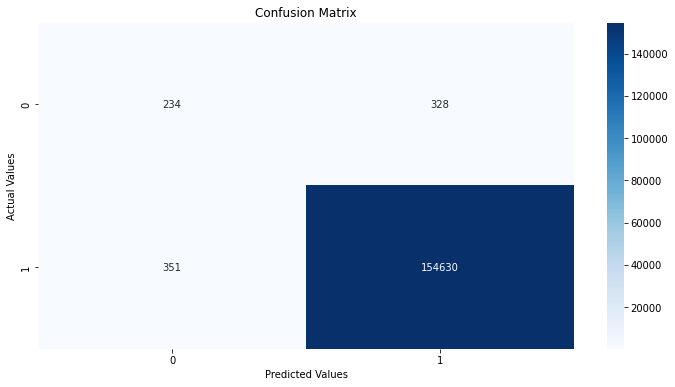

In [33]:
train_model_and_evaluate(model,X_train, y_train, X_test, y_test)

# The problem here is that due to unbalance data the model can not correctly classify if the Applicant is Bad. Let's balance the data using Oversampling technique

In [34]:

ros = RandomOverSampler(random_state=0)

ros.fit(X_train, y_train)
x_underesampled, y_underesampled = ros.fit_resample(x,y)


In [35]:
y_underesampled.value_counts()

1    774887
0    774887
Name: TARGET, dtype: int64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(x_underesampled, y_underesampled, test_size=0.1, random_state = 0)

In [42]:
print(y_test.value_counts())
print(y_train.value_counts())


0    77648
1    77330
Name: TARGET, dtype: int64
1    697557
0    697239
Name: TARGET, dtype: int64


The Accuracy for Test Set is: 99.75


True

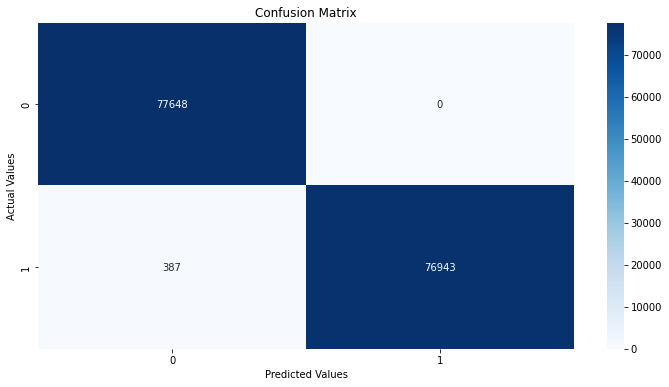

In [48]:
model = DecisionTreeClassifier()
train_model_and_evaluate(model, X_train, y_train, X_test, y_test)

ii. Random Forest

In [44]:
model = RandomForestClassifier(random_state=0)

The Accuracy for Test Set is: 99.75


True

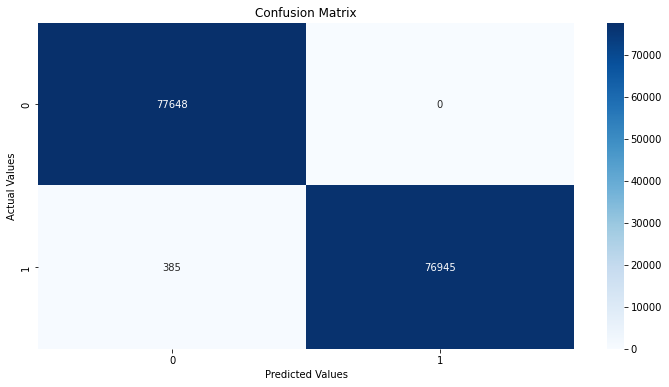

In [45]:
train_model_and_evaluate(model, X_train, y_train, X_test, y_test)

iii. XGBoost

In [46]:
model = XGBClassifier(random_state=0, alpha = 0.5, eta=0.1)

C:\Users\904244\.conda\envs\credit_card\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy for Test Set is: 93.09


True

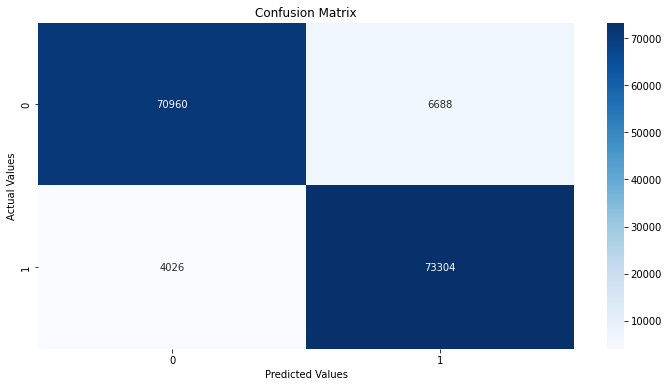

In [47]:
train_model_and_evaluate(model, X_train, y_train, X_test, y_test)

# Decision Tree and Random Forest performed well since they classified the Bad applicants correctly.